## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import os

from utils import *

## Importing Data

In [ ]:
ticker = 'AAPL'
today = pd.Timestamp.now().strftime("%Y-%m-%d")

if not os.path.exists(f'{ticker}_{today}.csv'):
    df = get_data(ticker, interval='1d', period='10y')
    df.to_csv(f'{ticker}_{today}.csv')
else:
    df = pd.read_csv(f'{ticker}_{today}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

In [3]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-03-09,28.39,28.94,27.93,28.58,354114000
2015-03-10,27.81,28.41,27.65,28.23,275426400
2015-03-11,27.30,27.86,27.27,27.86,275756000
2015-03-12,27.79,27.89,27.16,27.32,193450800
2015-03-13,27.60,28.01,27.38,27.78,207309200


## Price Chart

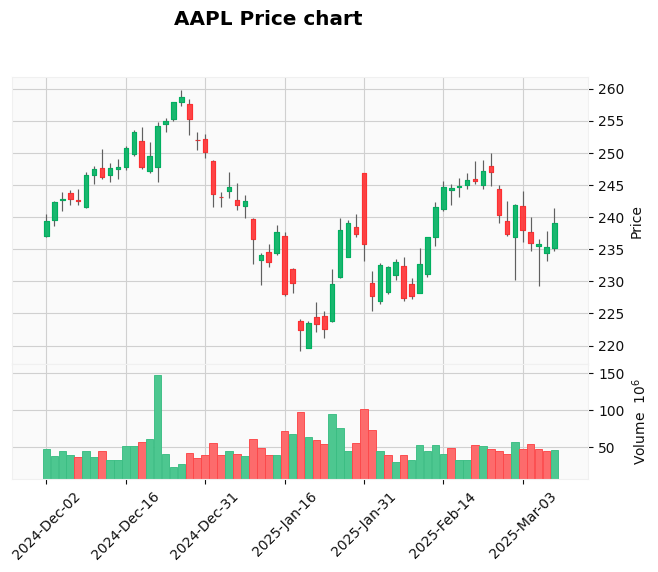

In [4]:
price_chart(df)


## Generating Technical Indicators

In [5]:
df.ta.rsi(length=14, append=True) 
df.ta.ema(length=20, append=True)
df.ta.ema(length=50, append=True)
df.ta.ema(length=200, append=True) 



# drop rows with NaN values because of shift in EMA calculation
df.dropna(inplace=True)

# we determined from feature importance on random forest that Open, High, Low are not important
df.drop(columns=['Open', 'High', 'Low'], inplace=True) 

df.tail()

,Close,Volume,RSI_14,EMA_20,EMA_50,EMA_200
Date,,,,,,
2025-03-03,238.03,47184000,48.447193,239.755051,238.174268,224.429455
2025-03-04,235.93,53798100,45.885179,239.390761,238.086257,224.543888
2025-03-05,235.74,47227600,45.649960,239.043069,237.994247,224.655293
2025-03-06,235.33,45170400,45.112542,238.689443,237.889767,224.761509
2025-03-07,239.07,46245700,50.802242,238.725687,237.936051,224.903882


## Defining entry points

In [6]:
df['buy'] = (
    (df['RSI_14'] < 45) &  
    (df['EMA_20'] >= 0.98 * df['EMA_50']) &  
    (df['Close'] >= 0.95 * df['EMA_200'])
).astype(int)

# save df with indicators and buy columns
#df.to_csv(f'TA_AAPL_{pd.Timestamp.now().strftime("%Y-%m-%d")}.csv')

df['buy'].value_counts()

buy
0    1975
1     342
Name: count, dtype: int64

<Axes: >

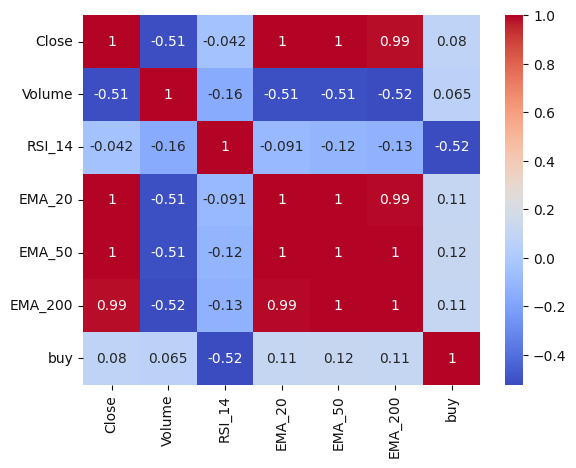

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Classifying the data

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data splitting

In [9]:
X = df.drop(columns=['buy'])
y = df['buy']

scaler = StandardScaler() # not necessary for Random Forest, will be useful for other models
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)


### Random Forest training

In [10]:
classifier_RR = RandomForestClassifier(n_estimators=50, random_state=42)
classifier_RR.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

### Model evaluation

In [11]:
y_pred_RR = classifier_RR.predict(X_test)

print(classification_report(y_test, y_pred_RR))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.97      0.94      0.96        68

    accuracy                           0.99       464
   macro avg       0.98      0.97      0.97       464
weighted avg       0.99      0.99      0.99       464



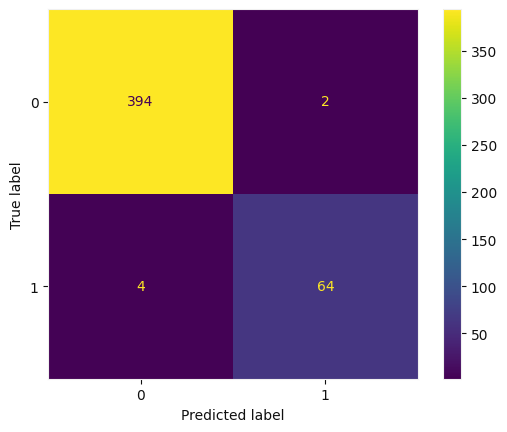

In [12]:
cm = confusion_matrix(y_test, y_pred_RR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### features importance

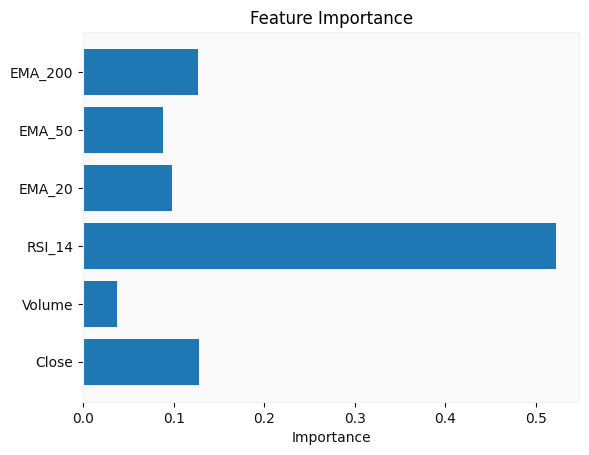

In [13]:
plt.barh(X.columns, classifier_RR.feature_importances_)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

### SVM and KNN training

In [14]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'], 
    'kernel': ['rbf']
}


svm = SVC(class_weight='balanced', random_state=42)


grid_search = GridSearchCV(svm, param_grid, 
                           scoring=['f1', 'accuracy'],
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train, y_train)


print('param:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_svm = grid_search.best_estimator_


y_pred_svm = best_svm.predict(X_test)
print('SVM Classification Report:\n', classification_report(y_test, y_pred_svm))
confusion_matrix(y_test, y_pred_svm)

param: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
f1: 0.8981196183599366
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.96      0.94      0.95        68

    accuracy                           0.98       464
   macro avg       0.97      0.97      0.97       464
weighted avg       0.98      0.98      0.98       464



array([[393,   3],
       [  4,  64]])

In [15]:
param_grid = {
    'n_neighbors': range(1, 21),
    'p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}


knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid,
                           scoring=['f1', 'accuracy'], 
                           n_jobs=-1, refit='f1')
grid_search.fit(X_train, y_train)


print('params:', grid_search.best_params_)
print('f1:', grid_search.best_score_)


best_knn = grid_search.best_estimator_


y_pred_knn = best_knn.predict(X_test)
print('KNN Classification Report:\n', classification_report(y_test, y_pred_knn))
confusion_matrix(y_test, y_pred_knn)

params: {'n_neighbors': 1, 'p': 1}
f1: 0.8447759252593949
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       396
           1       0.89      0.84      0.86        68

    accuracy                           0.96       464
   macro avg       0.93      0.91      0.92       464
weighted avg       0.96      0.96      0.96       464



array([[389,   7],
       [ 11,  57]])